In [1]:
import itertools
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [2]:
pjme = pd.read_excel(r'E:/Demand_forecasting_assignment/data.xlsx',
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates
pjme.head()

,SKU_Code,Units_Sold
Week_Date,,
2017-01-01,2001 - 1173465,0.0
2017-01-08,2001 - 1173465,0.0
2017-01-15,2001 - 1173465,0.0
2017-01-22,2001 - 1173465,0.0
2017-01-29,2001 - 1173465,0.0


In [3]:
pjme = pjme.drop('SKU_Code',axis = 1)

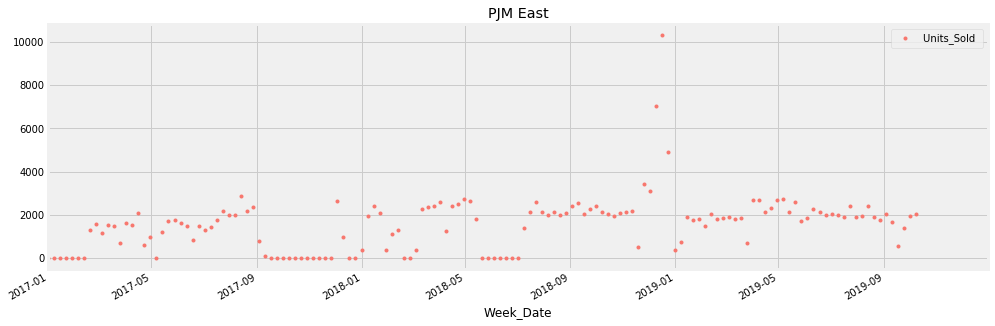

In [4]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

In [5]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='Units_Sold ')

features_and_target = pd.concat([X, y], axis=1)

In [12]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Units_Sold
Week_Date,,,,,,,,,
2017-01-01,0,6,1,1,2017,1,1,52,0.0
2017-01-08,0,6,1,1,2017,8,8,1,0.0
2017-01-15,0,6,1,1,2017,15,15,2,0.0
2017-01-22,0,6,1,1,2017,22,22,3,0.0
2017-01-29,0,6,1,1,2017,29,29,4,0.0


# Train/Test Split


In [18]:
split_date = '09-Apr-2019'
last_date_test = '08-Oct-2019'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index < last_date_test].copy()
print(pjme_test.tail())

            Units_Sold 
Week_Date              
2019-09-03       2035.0
2019-09-10       1663.0
2019-09-17        534.0
2019-09-24       1372.0
2019-10-01       1927.0


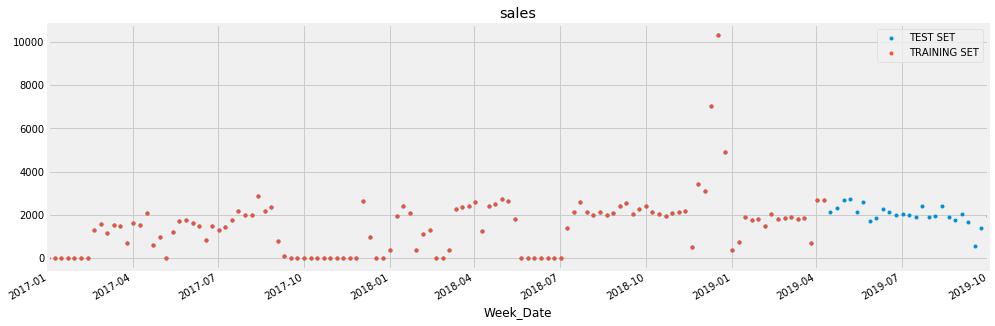

In [19]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'Units_Sold ': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'Units_Sold ': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='sales', style='.')
plt.show()

# Simple Prophet Model-

In [20]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Week_Date':'ds',
                     'Units_Sold ':'y'}).head()

,ds,y
0,2017-01-01,0.0
1,2017-01-08,0.0
2,2017-01-15,0.0
3,2017-01-22,0.0
4,2017-01-29,0.0


In [21]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Week_Date':'ds',
                               'Units_Sold ':'y'}))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\RONAK JAIN\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [22]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Week_Date':'ds'}))

In [23]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,571.969053,-1370.795762,1439.622388,571.969053,571.969053,-574.885176,-574.885176,-574.885176,-574.885176,-574.885176,-574.885176,0.0,0.0,0.0,-2.916123
1,2017-01-08,587.522833,-1677.007473,1160.089222,587.522833,587.522833,-822.857627,-822.857627,-822.857627,-822.857627,-822.857627,-822.857627,0.0,0.0,0.0,-235.334794
2,2017-01-15,603.076614,-1124.491272,1581.467000,603.076614,603.076614,-378.647680,-378.647680,-378.647680,-378.647680,-378.647680,-378.647680,0.0,0.0,0.0,224.428934
3,2017-01-22,618.630394,-786.915035,1998.509834,618.630394,618.630394,-50.764206,-50.764206,-50.764206,-50.764206,-50.764206,-50.764206,0.0,0.0,0.0,567.866188
4,2017-01-29,634.184174,-908.669431,1873.498038,634.184174,634.184174,-246.664651,-246.664651,-246.664651,-246.664651,-246.664651,-246.664651,0.0,0.0,0.0,387.519524


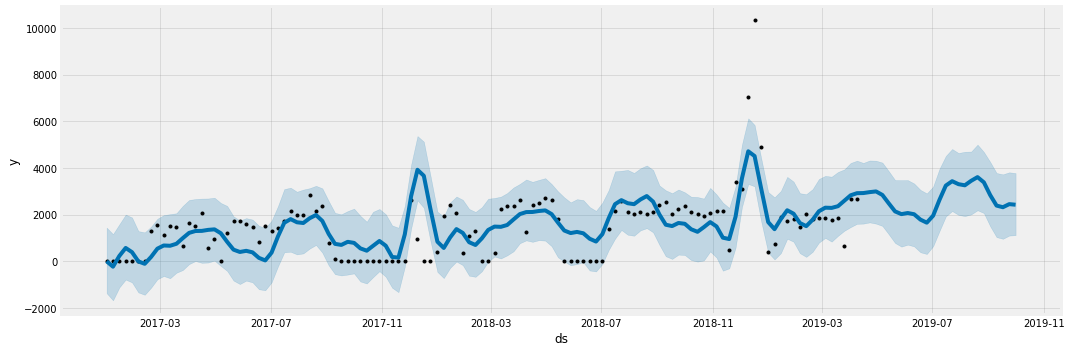

In [24]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

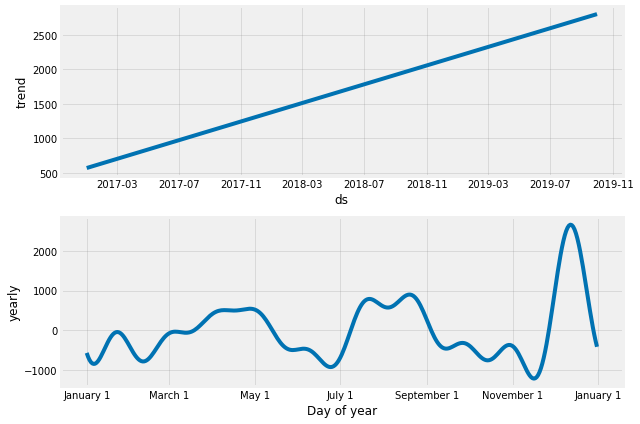

In [25]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

# Compare Forecast to Actuals

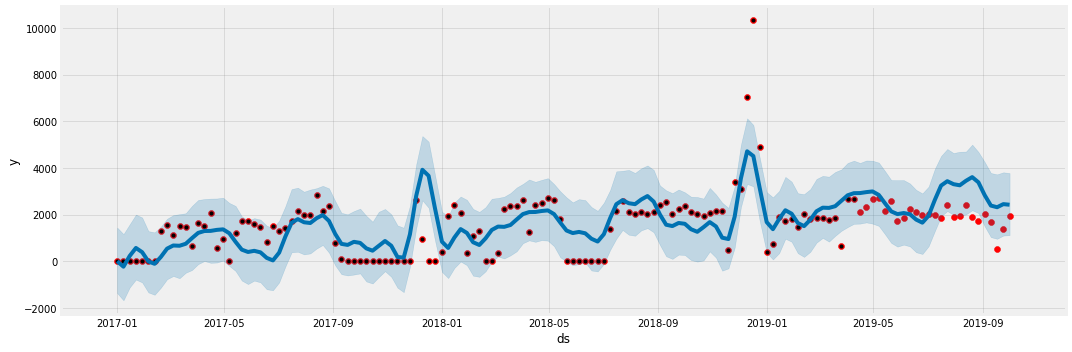

In [26]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['Units_Sold '], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Error Metrics

In [36]:
mean_squared_error(y_true=pjme_test['Units_Sold '],
                   y_pred=pjme_test_fcst['yhat'])

1080451.912638709

In [37]:
mean_absolute_error(y_true=pjme_test['Units_Sold '],
                   y_pred=pjme_test_fcst['yhat'])

770.3682084215775

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['Units_Sold '],
                   y_pred=pjme_test_fcst['yhat'])

C:\Users\RONAK JAIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



inf